# Gaussian Process implementation with JAX 

Importing the necessary packages

In [1]:
import gp
import jax.numpy as jnp
from jax import jacrev, jit, lax, random, tree_map, vmap
import matplotlib.pyplot as plt
from jax import random
from functools import partial
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from jax.scipy.optimize import minimize
from scipy.optimize import minimize

Prior
使用RBF-kernel：
$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)\tag{1}
$$

In [2]:
key = random.PRNGKey(42)
X = jnp.arange(-5, 5, 0.2).reshape(-1, 1)
mu = jnp.zeros(X.shape)
cov = gp.kernel(X,X)

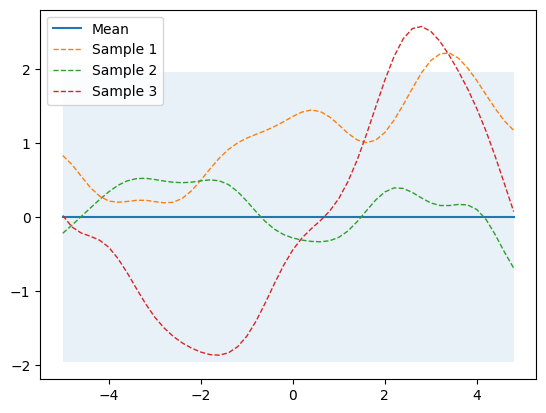

In [3]:
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)
gp.plot_gp(mu, cov, X, samples=samples)

Posterior


In [4]:
X_train = jnp.arange(-3, 4, 1).reshape(-1, 1)
def f(x):
    return jnp.sin(x)

In [5]:
# no noise y
Y_train = vmap(f)(*X_train.T)
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = gp.predict(X, X_train, Y_train)

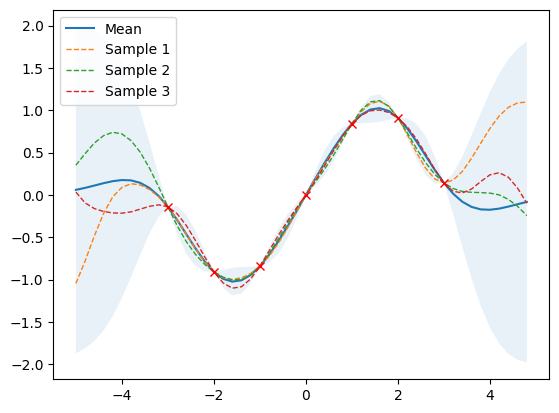

In [6]:
# plot
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
gp.plot_gp(mu_s, cov_s, X, X_train, Y_train, samples=samples)

In [7]:
# noise data
noise = 1.0
X_train = jnp.arange(-3, 4, 1).reshape(-1, 1)
noise_values = noise * random.normal(key, shape=X_train.shape)
Y_train = jnp.sin(X_train) + noise_values

In [8]:
# Compute mean and covariance of the posterior distribution
mu_s, cov_s = gp.predict(X, X_train, Y_train, sigma_y=noise)

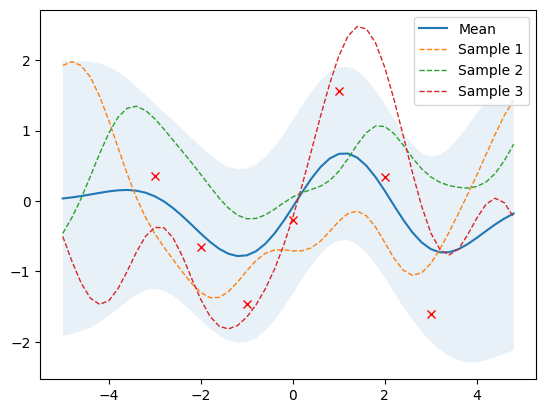

In [9]:
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
gp.plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

log marginal likelihood
$$
\log p(\mathbf{y} | \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} | \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi)
$$
By minimizing the negative log marginal likelihood, you can find the optimal hyperparameter values so that the Gaussian process best fits the observed data.

Minimize the negative log-likelihood w.r.t. parameters l and sigma_f. We should actually run the minimization several times with different initializations to avoid local minima but this is skipped here for simplicity.

In [10]:
noise = 0.5
X_train = jnp.arange(-3, 4, 1).reshape(-1, 1)
noise_values = noise * random.normal(key, shape=X_train.shape)
Y_train = jnp.sin(X_train) + noise_values
Y_train = Y_train.ravel()

In [11]:
initial_theta = jnp.array([1.0,1.0])
num_steps = 40
lr = 0.01
result = gp.optimize_mll(initial_theta, X_train, Y_train, noise, num_steps, lr, method='SGD')
l_opt, sigma_f_opt = result
print(l_opt, sigma_f_opt)

1.1158627 0.6801871


Compute posterior mean and covariance with optimized kernel parameters and plot the results

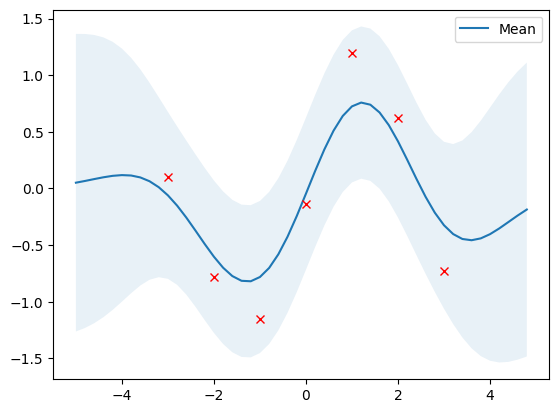

In [12]:
mu_s, cov_s = gp.predict(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
gp.plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)